<a href="https://colab.research.google.com/github/ThomasAlbin/Astroniz-YT-Tutorials/blob/main/SPICE-Lecture/SPICE_Overview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SPICE Workshop - Crash Course

In this markdown script we are covering some SPICE and kernel functionalities. This script shall work flawlessly on the hub.bwjupyter.de server, as well as on Google Colab.

Please note: all commands that start with "!" escape the runtime and enable one to execute bash commands like pip install or wget to obtain kernels from the miscellaneos repos.

A dedicated SPICE course will be provided (or is already, depending when you check the script).

Additionally I want to state that Jupyter Notebooks are a great resource to leanr stuff. However it is NOT suitable to develop and deploy productive code. Keep this in mind and learn best practices. If you need further information, visit me in the 2nd cubicle on the 1st floor, or write me an E-Mail via: albint@irs.uni-stuttgart.de

In [1]:
# We need to install miscellanous libraries that are not part of the
!pip install spiceypy
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 9.2 MB/s eta 0:00:00


In [2]:
import datetime
import glob

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import spiceypy

## Earth's position & velocity

In this cell we are checking the distance between the Earth and Sun. Is the Earth "really" 1 AU away from the Sun? And what is the velocity? Does it fit with the theoretical expectations?

In [3]:
# First we need to download some kernels

# Leapseconds
!curl https://naif.jpl.nasa.gov/pub/naif/generic_kernels/lsk/naif0012.tls --create-dirs -o kernels/lsk/naif0012.tls

# SPK
!curl https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/de432s.bsp --create-dirs -o kernels/spk/de432s.bsp

# PCK
!curl https://naif.jpl.nasa.gov/pub/naif/generic_kernels/pck/gm_de440.tpc --create-dirs -o kernels/pck/gm_de440.tpc

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5257  100  5257    0     0  15181      0 --:--:-- --:--:-- --:--:-- 15193
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.3M  100 10.3M    0     0  10.9M      0 --:--:-- --:--:-- --:--:-- 10.9M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12406  100 12406    0     0  30551      0 --:--:-- --:--:-- --:--:-- 30556


In [4]:
# Load the spice kernels
kernel_filepaths = glob.glob("kernels/**/*")
spiceypy.furnsh(kernel_filepaths)

In [5]:
# Determine the "current" datetime. It is a tiny fraction of what's possible.
# No number of supported time formats in SPICE? Yes:
# https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/C/req/time.html
datetime_now = datetime.datetime.today()
datetime_now = datetime_now.strftime('%Y-%m-%dT%H:%M:%S')

# convert the datetime to a string, replacing the time with midnight
print(f"Basically... now (in UTC): {datetime_now}")

Basically... now (in UTC): 2025-12-15T16:47:09


In [6]:
# In Ephemeris Time
et_now = spiceypy.utc2et(datetime_now)
print(f"The Ephemeris Time: {et_now}")

The Ephemeris Time: 819089298.183458


In [7]:
# Compute the state vector of the Earth w.r.t. the Sun
# The target and observer are provided as NAIF Integer ID codes. A list of IDs is provided here:
# https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/C/req/naif_ids.html
earth_state_wrt_sun, earth_sun_light_time = spiceypy.spkgeo(targ=399,
                                                            et=et_now,
                                                            ref='ECLIPJ2000',
                                                            obs=10)

# Please note: there are not corrections applied! Take a look e.g. here:
# https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/FORTRAN/spicelib/spkaps.html
# https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/FORTRAN/spicelib/spkacs.html

# In this case we consider it "as is" without any applied correction

print(earth_state_wrt_sun)

[ 1.63968787e+07  1.46329295e+08 -8.47540193e+03 -3.00941834e+01
  3.21397023e+00  5.89808845e-04]


In [8]:
# The light travel time between Earth and the Sun:
earth_sun_lt_min = earth_sun_light_time / 60
print(f"Light travel time between Earth and Sun: {earth_sun_lt_min}")

Light travel time between Earth and Sun: 8.185946564330939


In [9]:
# Distance between Earth and Sun
earth_sun_dist_km = np.linalg.norm(earth_state_wrt_sun[:3])
print(f"Distance between Earth and Sun in km: {earth_sun_dist_km}")

Distance between Earth and Sun in km: 147245102.49464566


In [10]:
# ... pretty unhandy. Let's compute it in Astronomical Units (AU). It should be 1, right???
earth_sun_dist_au = spiceypy.convrt(earth_sun_dist_km, 'km', 'AU')
print(f"Distance between Earth and Sun in AU: {earth_sun_dist_au}")

Distance between Earth and Sun in AU: 0.984272716520686


### Earth's Orbital Elements

Depending on when you compute the state vector of our home planet your will get a distance between Earth and Sun that is larger or smaller 1! That's because the Earth is not on a "100 %" perfect circle. It is moving in an elliptical orbit. The "elliptic-ness" is defined by the eccentricity *e*; one of the 6 Keplerian Elements that define the shape and orientation of an orbit (a 7th value determines the position of an object).

Circular Orbit: $e$\
Elliptic Orbit: $0<e<1$\
Parabolic Orbit: $e=1$\
Hyperbolic Orbit: $e>1$

In [11]:
# To compute the orbital / keplerian elements, based on a state vector, we can use:
# https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/FORTRAN/spicelib/oscelt.html
# https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/FORTRAN/spicelib/oscltx.html
# The latter provides the semi-major axis, true anomaly and orbital period.

# First we need to set the gravitational parameter
_, grav_mu = spiceypy.bodvrd("SUN", "GM", 1)
grav_mu = grav_mu[0]
print(grav_mu)

132712440041.27939


In [12]:
# Computing the keplerian elements
(earth_peri_km,
 earth_ecc,
 earth_incl_rad,
 earth_lnode_asc_rad,
 earth_argp_rad,
 m0_rad,
 t0,
 mu) = spiceypy.oscelt(earth_state_wrt_sun, et_now, grav_mu)

print(f"Earth's eccentricity: {earth_ecc}")

Earth's eccentricity: 0.017102795154364223


In [13]:
# Does the eccentrictiy change over time? Or is everything stable and nice? Let's plot for example the eccentrictiy / inclination changes.
start_date = "2025-01-01"
end_date = "2026-01-01"

comp_days = np.arange(start_date, end_date, dtype='datetime64[D]')
comp_days = comp_days.astype(str)

print(comp_days)

['2025-01-01' '2025-01-02' '2025-01-03' '2025-01-04' '2025-01-05'
 '2025-01-06' '2025-01-07' '2025-01-08' '2025-01-09' '2025-01-10'
 '2025-01-11' '2025-01-12' '2025-01-13' '2025-01-14' '2025-01-15'
 '2025-01-16' '2025-01-17' '2025-01-18' '2025-01-19' '2025-01-20'
 '2025-01-21' '2025-01-22' '2025-01-23' '2025-01-24' '2025-01-25'
 '2025-01-26' '2025-01-27' '2025-01-28' '2025-01-29' '2025-01-30'
 '2025-01-31' '2025-02-01' '2025-02-02' '2025-02-03' '2025-02-04'
 '2025-02-05' '2025-02-06' '2025-02-07' '2025-02-08' '2025-02-09'
 '2025-02-10' '2025-02-11' '2025-02-12' '2025-02-13' '2025-02-14'
 '2025-02-15' '2025-02-16' '2025-02-17' '2025-02-18' '2025-02-19'
 '2025-02-20' '2025-02-21' '2025-02-22' '2025-02-23' '2025-02-24'
 '2025-02-25' '2025-02-26' '2025-02-27' '2025-02-28' '2025-03-01'
 '2025-03-02' '2025-03-03' '2025-03-04' '2025-03-05' '2025-03-06'
 '2025-03-07' '2025-03-08' '2025-03-09' '2025-03-10' '2025-03-11'
 '2025-03-12' '2025-03-13' '2025-03-14' '2025-03-15' '2025-03-16'
 '2025-03-

In [14]:
# Set the dates ...
elements_df = pd.DataFrame(comp_days, columns=["date"])

In [15]:
elements_df

,date
0,2025-01-01
1,2025-01-02
2,2025-01-03
3,2025-01-04
4,2025-01-05
...,...
360,2025-12-27
361,2025-12-28
362,2025-12-29
363,2025-12-30


In [16]:
# ... compute the ET ...
elements_df.loc[:, "et"] = elements_df["date"].apply(lambda x: spiceypy.utc2et(x))

In [17]:
# ... and the state + conical elements
elements_df.loc[:, "earth_state"] = elements_df["et"].apply(lambda x: spiceypy.spkgeo(targ=399, et=x, ref='ECLIPJ2000', obs=10)[0])

col_names = ["earth_peri_km", "earth_ecc", "earth_incl_rad", "earth_lnode_asc_rad", "earth_argp_rad", "m0_rad", "t0", "mu"]

elements_df[col_names] = [
    spiceypy.oscelt(state, et, grav_mu)
    for state, et in zip(elements_df["earth_state"], elements_df["et"])
]

In [18]:
elements_df

,date,et,earth_state,earth_peri_km,earth_ecc,earth_incl_rad,earth_lnode_asc_rad,earth_argp_rad,m0_rad,t0,mu
0,2025-01-01,7.889617e+08,"[-26732723.48115522, 144658184.58113536, -7643...",1.471048e+08,0.017565,0.000052,3.319238,4.764250,6.238038,7.889617e+08,1.327124e+11
1,2025-01-02,7.890481e+08,"[-29302156.60364332, 144157808.32774538, -7651...",1.471042e+08,0.017503,0.000052,3.459478,4.629420,6.249990,7.890481e+08,1.327124e+11
2,2025-01-03,7.891345e+08,"[-31862317.338707764, 143612368.51572078, -767...",1.471039e+08,0.017400,0.000053,3.575531,4.518366,6.262339,7.891345e+08,1.327124e+11
3,2025-01-04,7.892209e+08,"[-34412362.275784515, 143022073.34945244, -770...",1.471037e+08,0.017259,0.000055,3.659727,4.438421,6.275413,7.892209e+08,1.327124e+11
4,2025-01-05,7.893073e+08,"[-36951461.83740085, 142387156.97229698, -7752...",1.471037e+08,0.017086,0.000055,3.708617,4.392718,0.006338,7.893073e+08,1.327124e+11
...,...,...,...,...,...,...,...,...,...,...,...
360,2025-12-27,8.200657e+08,"[-13118332.353613049, 146542083.79277813, -878...",1.470970e+08,0.016835,0.000064,3.618656,4.484634,6.128458,8.200657e+08,1.327124e+11
361,2025-12-28,8.201521e+08,"[-15721374.13557042, 146279143.5524698, -8839....",1.470965e+08,0.016640,0.000063,3.572976,4.532457,6.143528,8.201521e+08,1.327124e+11
362,2025-12-29,8.202385e+08,"[-18319270.021385916, 145970736.13510263, -888...",1.470965e+08,0.016438,0.000062,3.495180,4.610915,6.160041,8.202385e+08,1.327124e+11
363,2025-12-30,8.203249e+08,"[-20911222.427413493, 145617014.66198355, -891...",1.470970e+08,0.016242,0.000061,3.385165,4.719915,6.178191,8.203249e+08,1.327124e+11


In [19]:
# Now we plot the ecc vs. incl (in degrees) in an interactive plotly
x = np.degrees(elements_df["earth_incl_rad"])
y = np.degrees(elements_df["earth_ecc"])

N = len(x)

path_data = np.column_stack((x, y))

# 2. Define the Frames
# We create a list of frames. Each frame represents one "step" of the dot.
# We set traces=[1] so we only update the Dot (Trace 1), not the Line (Trace 0).
frames = [
    go.Frame(
        data=[go.Scatter(x=[path_data[k, 0]], y=[path_data[k, 1]])],
        name=str(k),
        traces=[1]
    )
    for k in range(N)
]

# 3. Create the Base Figure
fig = go.Figure(
    data=[
        # Trace 0: The Static Line
        go.Scatter(
            x=path_data[:, 0],
            y=path_data[:, 1],
            mode='lines',
            line=dict(color='gray', width=2),
            name='Path'
        ),
        # Trace 1: The Moving Dot (Initial Position)
        go.Scatter(
            x=[path_data[0, 0]],
            y=[path_data[0, 1]],
            mode='markers',
            marker=dict(color='red', size=12),
            name='Current Position'
        )
    ],
    frames=frames
)

# 4. Configure the Slider
# The slider steps tell Plotly which frame to animate to when dragged.
sliders = [dict(
    steps=[
        dict(
            method='animate',
            # The args here ensure the transition is instant (duration=0)
            # so the slider feels responsive like a UI control, not a slow movie.
            args=[[str(k)], dict(mode='immediate', frame=dict(duration=0, redraw=False), transition=dict(duration=0))],
            label=str(k)
        ) for k in range(N)
    ],
    active=0,
    transition=dict(duration=0),
    x=0, # Slider position settings
    y=0,
    currentvalue=dict(font=dict(size=12), prefix='Index: ', visible=True),
    len=1.0 # Slider length (1.0 = 100% width)
)]

# 5. Final Layout
fig.update_layout(
    title="Plotly-Only Slider Animation",
    sliders=sliders,
    xaxis_title="Incl. in deg",
    yaxis_title="Eccentricity",
    height=600,
    template="plotly_white"
)

fig.show()

### Earth's Orbital Speed

In [20]:
# Compute the actual orbital speed of the Earth around the Sun
earth_orb_speed_wrt_sun = np.linalg.norm(earth_state_wrt_sun[3:])

# It's around 30 km/s
print(f'Current orbital speed of the Earth around the Sun in km/s: {earth_orb_speed_wrt_sun}')

Current orbital speed of the Earth around the Sun in km/s: 30.265318113891123


In [21]:
# Compute the orbital speed
v_orb_func = lambda gm, r: np.sqrt(gm/r)
earth_orb_speed_wrt_sun_theory = v_orb_func(grav_mu, earth_sun_dist_km)

# Print the result
print(f'Theoretical orbital speed of the Earth around the Sun in km/s: '
      + f'{earth_orb_speed_wrt_sun_theory}')

Theoretical orbital speed of the Earth around the Sun in km/s: 30.021707390078287


## Vernal Equinox

When is Earth at [1 AU, 0 AU, 0 AU]? For this, we use some more advanced method in SPICE that searches for geometric events.

These kind of event finders can be used also for occulation occurances, close fly-bys etc.

In [22]:
et_start = spiceypy.str2et('2025-01-01')
et_end   = spiceypy.str2et('2026-01-01')

# Define the search window
cnfine = spiceypy.utils.support_types.SPICEDOUBLE_CELL(2)
spiceypy.wninsd(et_start, et_end, cnfine)

# Geometric "finder" settings and requirements
target = "EARTH"
frame  = "ECLIPJ2000"
abcorr = "NONE"
obsrvr = "SUN"

crdsys = "RECTANGULAR"  # We are using X, Y, Z
coord  = "Y"            # We are searching on the Y coordinate

relate = "="
refval = 0.0
adjust = 0.0
step   = 86400.0

# Result precision
result = spiceypy.utils.support_types.SPICEDOUBLE_CELL(100)

# Actual geometry finder
spiceypy.gfposc(target,
                frame,
                abcorr,
                obsrvr,
                crdsys,
                coord,
                relate,
                refval,
                adjust,
                step,
                1000,
                cnfine,
                result)

count = spiceypy.wncard(result)
print(f"Found {count} events where Earth crosses Y=0 (X-axis).")

# We have 2 "crossings" and need to find the one with x>0
for i in range(count):
    [left, right] = spiceypy.wnfetd(result, i)
    et_found = (left + right) / 2.0

    utc_time = spiceypy.et2utc(et_found, 'C', 3)
    state, _ = spiceypy.spkpos(target, et_found, frame, abcorr, obsrvr)

    # Filter for the positive X-axis in AU
    one_au = spiceypy.convrt(1, 'AU', 'km')
    if state[0] > 0:
        print(f"--- Match Found ---")
        print(f"Time (UTC): {utc_time}")
        print(f"Position (AU): X={(state[0]/one_au):.2f}, "\
              f"Y={(state[1]/one_au):.2f}, "\
              f"Z={(state[2]/one_au):.2f}")

Found 2 events where Earth crosses Y=0 (X-axis).
--- Match Found ---
Time (UTC): 2025 SEP 23 03:01:04.392
Position (AU): X=1.00, Y=-0.00, Z=-0.00


## Kernel Information

We got some first coding experience and intro of the SPICE API. But... let's dive in the kernels quickly to get a better understanding of them without switching back and forth between Python and the documentation

In [23]:
# First we unload all kernels
spiceypy.kclear()

In [24]:
# Success?
earth_state_wrt_sun, earth_sun_light_time = spiceypy.spkgeo(targ=399,
                                                            et=et_now,
                                                            ref='ECLIPJ2000',
                                                            obs=10)

SpiceNOLOADEDFILES: 
================================================================================

Toolkit version: CSPICE_N0067

SPICE(NOLOADEDFILES) --

At least one SPK file needs to be loaded by SPKLEF before beginning a search.

spkgeo_c --> SPKGEO --> SPKSFS

================================================================================

In [25]:
import spiceypy

# Path to kernel
kernel_path = "kernels/spk/de432s.bsp"

# Create a SPICE Integer Cell to hold the results
# Size '1000' is an arbitrary max number of IDs to hold
ids = spiceypy.utils.support_types.SPICEINT_CELL(1000)

# Extract objects from the specific file
spiceypy.spkobj(kernel_path, ids)

print(f"Objects in {kernel_path}:")
print("-" * 30)

# Iterate through the found IDs
for body_id in ids:
    try:
        # Try to convert the ID to a human-readable name
        name = spiceypy.bodc2n(body_id)
    except:
        # If no name is mapped in the toolkit, stick with the ID
        name = "Unknown Name"

    print(f"ID: {body_id:<10} | Name: {name}")

spiceypy.kclear()

Objects in kernels/spk/de432s.bsp:
------------------------------
ID: 1          | Name: MERCURY BARYCENTER
ID: 2          | Name: VENUS BARYCENTER
ID: 3          | Name: EARTH BARYCENTER
ID: 4          | Name: MARS BARYCENTER
ID: 5          | Name: JUPITER BARYCENTER
ID: 6          | Name: SATURN BARYCENTER
ID: 7          | Name: URANUS BARYCENTER
ID: 8          | Name: NEPTUNE BARYCENTER
ID: 9          | Name: PLUTO BARYCENTER
ID: 10         | Name: SUN
ID: 199        | Name: MERCURY
ID: 299        | Name: VENUS
ID: 301        | Name: MOON
ID: 399        | Name: EARTH


In [26]:
# Load a leapseconds kernel (LSK) to convert internal times to UTC strings.
spiceypy.furnsh("kernels/lsk/naif0012.tls")

# Initialize a Cell to hold the Object IDs
ids = spiceypy.utils.support_types.SPICEINT_CELL(1000)

# Get the list of objects in the file
spiceypy.spkobj(kernel_path, ids)

data_list = []

# Iterate over every object ID found
for body_id in ids:

    #Get the Name
    try:
        name = spiceypy.bodc2n(body_id)
    except:
        name = str(body_id) # Fallback if name not known

    # Get the Time Coverage for this specific body
    # We need a 'Window' (Double Cell) to store the result
    cover = spiceypy.utils.support_types.SPICEDOUBLE_CELL(2000)
    spiceypy.spkcov(kernel_path, body_id, cover)

    # The coverage might consist of multiple intervals (gaps in data).
    # We usually just want the absolute start and absolute end.
    card = spiceypy.wncard(cover) # Get number of intervals

    # Get the very first start time and very last end time
    start_et, _ = spiceypy.wnfetd(cover, 0)         # First interval start
    _, end_et   = spiceypy.wnfetd(cover, card - 1)  # Last interval end

    # Convert to UTC String
    start_utc = spiceypy.et2utc(start_et, 'C', 3)
    end_utc   = spiceypy.et2utc(end_et, 'C', 3)

    data_list.append({
            "NAIF ID": body_id,
            "Name": name,
            "Start (UTC)": start_utc,
            "End (UTC)": end_utc
        })

df = pd.DataFrame(data_list)

# Optional: Adjust display options to prevent truncation of long timestamps
#pd.set_option('display.max_colwidth', None)

df

#spiceypy.kclear()

,NAIF ID,Name,Start (UTC),End (UTC)
0,1,MERCURY BARYCENTER,1949 DEC 13 23:59:18.817,2050 JAN 01 23:58:50.816
1,2,VENUS BARYCENTER,1949 DEC 13 23:59:18.817,2050 JAN 01 23:58:50.816
2,3,EARTH BARYCENTER,1949 DEC 13 23:59:18.817,2050 JAN 01 23:58:50.816
3,4,MARS BARYCENTER,1949 DEC 13 23:59:18.817,2050 JAN 01 23:58:50.816
4,5,JUPITER BARYCENTER,1949 DEC 13 23:59:18.817,2050 JAN 01 23:58:50.816
5,6,SATURN BARYCENTER,1949 DEC 13 23:59:18.817,2050 JAN 01 23:58:50.816
6,7,URANUS BARYCENTER,1949 DEC 13 23:59:18.817,2050 JAN 01 23:58:50.816
7,8,NEPTUNE BARYCENTER,1949 DEC 13 23:59:18.817,2050 JAN 01 23:58:50.816
8,9,PLUTO BARYCENTER,1949 DEC 13 23:59:18.817,2050 JAN 01 23:58:50.816
9,10,SUN,1949 DEC 13 23:59:18.817,2050 JAN 01 23:58:50.816


## Objects in the Sky (or on surfaces)

As mentioned in the lecture, there is a difference between considers "as is" states and light-time corrections. How significant is it when we observe e.g. Saturn from Earth?

In [27]:
!curl https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/satellites/sat415.bsp -o kernels/spk/sat415.bsp

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  595M  100  595M    0     0  12.1M      0  0:00:49  0:00:49 --:--:-- 13.7M


In [28]:
# Load the spice kernels
kernel_filepaths = glob.glob("kernels/**/*")
spiceypy.furnsh(kernel_filepaths)

In [29]:
target   = "SATURN"
observer = "EARTH"
frame    = "J2000"

# Geometric Position (NONE) - "True" instantaneous position
pos_geo, _ = spiceypy.spkpos(target, et_now, frame, "NONE", observer)

# Apparent Position (LT+S) - Light Time + Stellar Aberration corrected
pos_app, _ = spiceypy.spkpos(target, et_now, frame, "LT+S", observer)

# Distance (Magnitude of the geometric vector)
dist_km = spiceypy.vnorm(pos_geo)
dist_au = spiceypy.convrt(dist_km, "KM", "AU")

# Angular Separation (Difference between the two vectors in Radians)
sep_rad = spiceypy.vsep(pos_geo, pos_app)

# Convert Radians to Degrees
sep_deg = sep_rad * spiceypy.dpr()

def deg_to_dms(degrees):
    d = int(degrees)
    m_float = (degrees - d) * 60
    m = int(m_float)
    s = (m_float - m) * 60
    return d, m, s

d, m, s = deg_to_dms(sep_deg)

print(f"--- Analysis for {datetime_now} UTC ---")
print(f"Target: {target} | Observer: {observer}")
print("-" * 40)
print(f"Current Distance: {dist_km:,.2f} km")
print(f"                  {dist_au:.6f} AU")
print("-" * 40)
print(f"Angular Error (Geo vs Apparent):")
print(f"Degrees: {sep_deg:.8f}°")
print(f"DMS:     {d}° {m}' {s:.4f}\"")

--- Analysis for 2025-12-15T16:47:09 UTC ---
Target: SATURN | Observer: EARTH
----------------------------------------
Current Distance: 1,413,321,800.93 km
                  9.447473 AU
----------------------------------------
Angular Error (Geo vs Apparent):
Degrees: 0.00171671°
DMS:     0° 0' 6.1802"


In [30]:
solsys_df = pd.DataFrame()

# Add the ET and the corresponding UTC date-time string
solsys_df.loc[:, 'ET'] = [et_now]
solsys_df.loc[:, 'UTC'] = [datetime_now]

# Set a dictionary that lists some body names and the corresponding NAIF ID
# code. Mars has the ID 499, however the loaded kernels do not contain the
# positional information. We use the Mars barycentre instead
SOLSYS_DICT = {'SUN': 10, 'VENUS': 299, 'MOON': 301, 'MARS': 4}

In [31]:
for body_name in SOLSYS_DICT:

    # First, compute the directional vector Earth - body in J2000. Use
    # LT+S light time correction. spkezp returns the directional vector and
    # light time. Apply [0] to get only the vector
    solsys_df.loc[:, f'dir_{body_name}_wrt_earth_ecl'] = \
        solsys_df['ET'].apply(lambda x: spiceypy.spkezp(targ=SOLSYS_DICT[body_name], \
                                                        et=x, \
                                                        ref='J2000', \
                                                        abcorr='LT+S', \
                                                        obs=399)[0])

    # Compute the longitude and latitude of the body in radians in ECLIPJ2000
    # using the function recrad. recrad returns the distance, longitude and
    # latitude value; thus, apply [1] and [2] to get the longitude and
    # latitude, respectively
    solsys_df.loc[:, f'{body_name}_long_rad_ecl'] = solsys_df[f'dir_{body_name}_wrt_earth_ecl'] \
                                                        .apply(lambda x: spiceypy.recrad(x)[1])

    solsys_df.loc[:, f'{body_name}_lat_rad_ecl'] = solsys_df[f'dir_{body_name}_wrt_earth_ecl'] \
                                                        .apply(lambda x: spiceypy.recrad(x)[2])



In [32]:
# Before we plot the data, we need to convert the longitude data into a
# matplotlib compatible format. We computed longitude values between 0 and
# 2*pi (360 degrees). matplotlib expects values between -pi and +pi. Further,
# sky maps count from 0 degrees longitude to the left. Thus we need also to
# invert the longitude values
for body_name in SOLSYS_DICT:

    solsys_df.loc[:, f'{body_name}_long_rad4plot_ecl'] = \
        solsys_df[f'{body_name}_long_rad_ecl'] \
            .apply(lambda x: -1*((x % np.pi) - np.pi) if x > np.pi \
                   else -1*x)

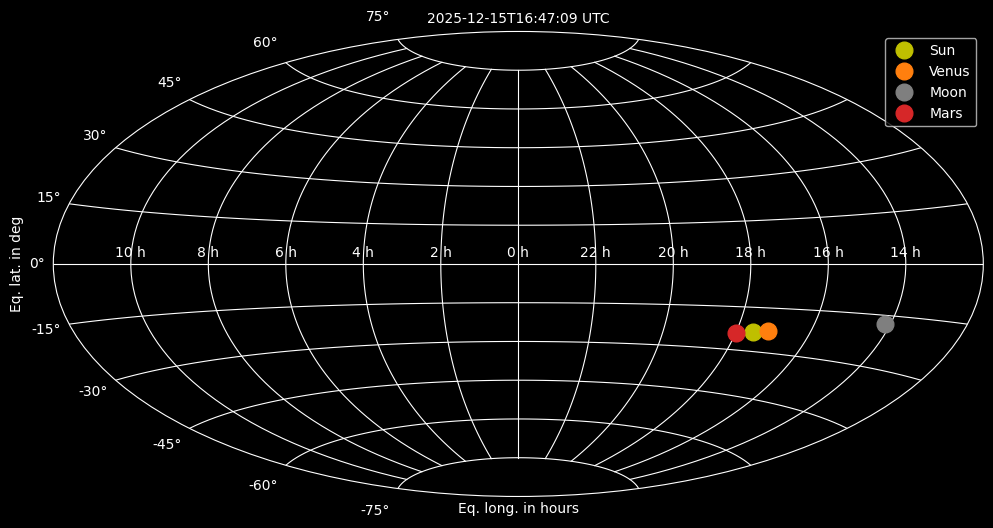

In [33]:
# Create now a sky map of the results

# Set a dark background (the night sky is ... dark)
plt.style.use('dark_background')

# Create a figure and then apply the aitoff projection
plt.figure(figsize=(12, 8))
plt.subplot(projection="aitoff")

# Set the UTC time string as a title
plt.title(f'{datetime_now} UTC', fontsize=10)

# Each body shall have an individual color; set a list with some colors
BODY_COLOR_ARRAY = ['y', 'tab:orange', 'tab:gray', 'tab:red']

# Iterate through the pandas dataframe. And plot each celestial body
for body_name, body_color in zip(SOLSYS_DICT, BODY_COLOR_ARRAY):

    # Plot the longitude and latitude data. Apply the color, and other
    # formatting parameters
    plt.plot(solsys_df[f'{body_name}_long_rad4plot_ecl'], \
             solsys_df[f'{body_name}_lat_rad_ecl'], \
             color=body_color, marker='o', linestyle='None', markersize=12, \
             label=body_name.capitalize())

# Replace the standard x ticks (longitude) with the ecliptic coordinates
plt.xticks(ticks=np.radians([-150, -120, -90, -60, -30, 0, \
                             30, 60, 90, 120, 150]),
           labels=['10 h', '8 h', '6 h', '4 h', '2 h', '0 h', \
                   '22 h', '20 h', '18 h', '16 h', '14 h'])

# Set the axes labels
plt.xlabel('Eq. long. in hours')
plt.ylabel('Eq. lat. in deg')

# Create a legend and grid
plt.legend()
plt.grid(True)

## 67P in 3D!

In [34]:
!curl https://naif.jpl.nasa.gov/pub/naif/ROSETTA/kernels/dsk/ROS_CG_K024_OMSDLAM_N_V1.OBJ --create-dirs -o kernels/dsk/ROS_CG_K024_OMSDLAM_N_V1.OBJ

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1576k  100 1576k    0     0  2110k      0 --:--:-- --:--:-- --:--:-- 2109k


In [35]:
DSK_PATH = "kernels/dsk/ROS_CG_K024_OMSDLAM_N_V1.OBJ"

comet_67p_shape_obj = pd.read_csv(DSK_PATH, \
                                  delim_whitespace=True, \
                                  names=["TYPE", "X1", "X2", "X3"])

/tmp/ipython-input-104476757.py:3: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



In [36]:
comet_67p_shape_obj

,TYPE,X1,X2,X3
0,v,-0.044832,-0.681758,-1.136887
1,v,-0.115582,-0.734195,-1.089813
2,v,-0.042360,-0.696320,-1.049685
3,v,-0.061455,-0.683615,-1.201943
4,v,-0.079385,-0.714186,-1.149147
...,...,...,...,...
36672,f,12227.000000,11215.000000,11660.000000
36673,f,10460.000000,11662.000000,11663.000000
36674,f,9419.000000,12025.000000,11666.000000
36675,f,9411.000000,9419.000000,11665.000000


In [37]:
# Handle the faces and vertices
vertices = comet_67p_shape_obj.loc[comet_67p_shape_obj["TYPE"] == "v"][["X1", "X2", "X3"]].values \
               .tolist()
faces = comet_67p_shape_obj.loc[comet_67p_shape_obj["TYPE"] == "f"][["X1", "X2", "X3"]].values

faces = faces - 1

# Convert the indices to integer
faces = faces.astype(int)

# Convert the numpy array to a Python list
faces = faces.tolist()

In [38]:
def plot_comet_dark_mode(vertices, faces):
    # Unpack the data
    v_arr = np.array(vertices)
    f_arr = np.array(faces)
    x, y, z = v_arr[:, 0], v_arr[:, 1], v_arr[:, 2]
    i, j, k = f_arr[:, 0], f_arr[:, 1], f_arr[:, 2]

    # Color Constants
    DARK_BG = 'rgb(25, 25, 25)'
    LIGHT_GREY_MESH = '#FFFFFF'
    WHITE_TEXT = '#FFFFFF'
    SUBTLE_GRID = 'rgb(60, 60, 60)'

    # Define the style for the X, Y, Z axes
    axis_style = dict(
        color=WHITE_TEXT,
        gridcolor=SUBTLE_GRID,
        zerolinecolor=SUBTLE_GRID,
        showbackground=False,
        title_font=dict(color=WHITE_TEXT)
    )

    # Build the Plotly Figure
    fig = go.Figure(data=[
        go.Mesh3d(
            x=x, y=y, z=z,
            i=i, j=j, k=k,
            color=LIGHT_GREY_MESH, # Set comet to light grey
            opacity=1.0,
            flatshading=False, # Essential for the "rocky" look under lighting
            name='67P',

            lighting=dict(
                ambient=0.5,
                diffuse=0.7,
                specular=0.4,
                roughness=0.1
            ),
            lightposition=dict(x=10000, y=0, z=0)
        )
    ])

    # Configure the Dark Layout
    fig.update_layout(
        title="3D Model of Comet 67P",
        width=900,
        height=800,
        paper_bgcolor=DARK_BG,
        font=dict(color=WHITE_TEXT),
        scene=dict(
            bgcolor=DARK_BG,

            xaxis=dict(**axis_style, title='X [km]'),
            yaxis=dict(**axis_style, title='Y [km]'),
            zaxis=dict(**axis_style, title='Z [km]'),

            # Ensure realistic proportions
            aspectmode='data',

            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.5)
            )
        ),
        margin=dict(r=20, l=20, b=20, t=50) # Tight margins
    )
    fig.show()

plot_comet_dark_mode(vertices, faces)

## Quo Vadis?

Currently, a detailed workshop is planned :)